# Stochastic Dual Coordinate Ascent

#### Guillaume DESFORGES, Michaël KARPE, Matthieu ROUX

###### Libraries importation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, minimize

# import bigfloat
# from lightning.classification import SDCAClassifier
# from lightning.regression import SDCARegressor

from copy import deepcopy
from malaptools import *

import warnings
warnings.filterwarnings('ignore')

###### Global variables

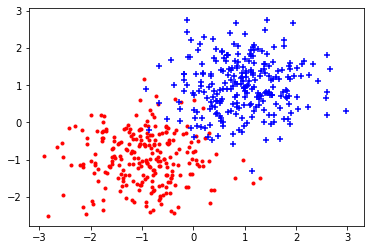

In [2]:
n = 500
d = 1
T = 500  # 500
lamb = 1

# X = np.random.rand(n,d)
# Y = np.random.rand(n)

# X = np.random.normal(0, 1, (n,d))
# Y = np.random.normal(0, 1, n)


def gen_linear(a, b, eps, nbex):
    X = np.array([np.random.uniform(-5, 5) for i in range(nbex)])
    Y = np.array([a * x + b + np.random.normal(0, np.sqrt(eps)) for x in X])
    return X.reshape(-1, 1), Y.reshape(-1, 1)


# X,Y = gen_linear(1,0,1,1000)
# plt.scatter(X,Y)

ratio = 0.8
n_train = n
n_test = n // 10 * 2  # car gen_arti doit avoir un nb d'échantillons pair...
X_train, y_train = gen_arti(data_type=0, sigma=0.5, nbex=n_train, epsilon=0.1)
X_test, y_test = gen_arti(data_type=0, sigma=0.5, nbex=n_test, epsilon=0.1)
plot_data(X_train, y_train)
plt.show()
# print(X_train)

###### Loss function

In [3]:
def phi(y, a, loss):
    if loss == "square_loss":
        return np.array([(a - y[i]) ** 2 for i in range(len(y))]).reshape(-1, 1)
    elif loss == "hinge_loss":
        return np.array([max(0, 1 - y[i] * a) for i in range(len(y))]).reshape(-1, 1)
    elif loss == "logistic_loss":
        return np.array([np.log(1 + np.exp(-y[i] * a)) for i in range(len(y))]).reshape(
            -1, 1
        )
    elif loss == "absolute_loss":
        return np.array([np.abs(a - y[i]) for i in range(len(y))]).reshape(-1, 1)
    elif loss == "smoothed_hinge_loss":
        return np.array([max(0, 1 - a) for i in range(len(y))]).reshape(-1, 1)

###### Convex conjugate in theory

In [4]:
def phi_star_theoric(y, u, loss):
    phi_0 = []
    for i in range(len(y)):

        def phi_i(z):
            return phi(y, z, loss)[i]

        def f(z):
            return -(z * u - phi_i(z))

        phi_0.append(-minimize_scalar(f).fun)
    return np.array(phi_0).reshape(-1, 1)

###### Convex conjugate for classic losses with closed forms

In [5]:
def phi_star(y, a, loss):
    if loss == "square_loss":
        return np.array([a * y[i] + a ** 2 / 4 for i in range(len(y))]).reshape(-1, 1)
    elif loss == "hinge_loss":
        return np.array([a * y[i] for i in range(len(y))]).reshape(-1, 1)
    elif loss == "logistic_loss":
        return np.array(
            [
                a * y[i] * np.log(-a * y[i]) + (1 + a * y[i]) * np.log(1 + a * y[i])
                for i in range(len(y))
            ]
        ).reshape(-1, 1)
    elif loss == "absolute_loss":
        return np.array([a * y[i] for i in range(len(y))]).reshape(-1, 1)
    elif loss == "smoothed_hinge_loss":
        return np.array([a * y[i] + gamma * a ** 2 / 2 for i in range(len(y))]).reshape(
            -1, 1
        )

###### Illustration of 'minimize_scalar' function: How does it work?

def f(x):
    return (x - 2) * x * (x + 2)**2

X = np.linspace(-2,2,100)
plt.plot(X,[f(x) for x in X])
plt.show()

res = minimize_scalar(f)

print(res)
print(res.x)
print(res.fun)

###### Computation of objective functions

In [6]:
def primal(y, x, w, loss):
    n = len(y)
    return (
        sum([phi(y, np.dot(x[i].T, w), loss)[i] for i in range(n)]) / n
        + lamb * np.linalg.norm(w) ** 2 / 2
    )

In [7]:
def w(alpha, x):
    n = len(alpha)
    d = len(x[0])
    # return np.vdot(alpha,x)/(lamb*n)
    # print("alpha x", [alpha[i]*x[i] for i in range(n)])
    return np.array(sum([[alpha[i] * x[i] for i in range(n)][j] for j in range(d)])) / (
        lamb * n
    )

In [8]:
def dual(y, x, alpha, loss):
    n = len(y)
    return (
        -sum([phi_star(y, -alpha[i], loss)[i] for i in range(n)]) / n
        - lamb * np.linalg.norm(w(alpha, x)) ** 2 / 2
    )

In [9]:
def nb_iter(L_lipschitz, eps_p):
    return (
        max(0, np.ceil(n * np.log(lamb * n / (2 * L_lipschitz ** 2))))
        + n
        + 20 * L_lipschitz ** 2 / (lamb * eps_p)
    )

In [10]:
def duality_gap(y, x, w_hat, alpha_hat, loss):
    return primal(y, x, w_hat, loss) - dual(y, x, alpha_hat, loss)

###### Closed forms for $\Delta \alpha_i$

In [11]:
gamma = 1


def incr_solution(y, a, loss, x, w):
    if loss == "square_loss":
        # print("x", x)
        # print("w", w)
        # print(np.dot(x.T,w))
        return (y - np.dot(x.T, w) - a / 2) / (0.5 + np.linalg.norm(x) ** 2 / (lamb * n))
    elif loss == "hinge_loss":
        return y * max(0, min(1, (1 - np.dot(x.T, w) * y) / (np.linalg.norm(x) ** 2 / (lamb * n)) + a * y)) - a
    elif loss == "absolute_loss":
        return max(-1, min(1, (y - np.dot(x.T, w) * y) / (np.linalg.norm(x) ** 2 / (lamb * n)) + a)) - a
    elif loss == "logistic_loss":
        return (y / (1 + np.exp(np.dot(x.T, w) * y)) - a) / max(1, 0.25 + np.linalg.norm(x) ** 2 / (lamb * n))
    elif loss == "smoothed_hinge_loss":
        return y * max(
            0,
            min(1, (1 - np.dot(x.T, w) * y - gamma * a * y) / (np.linalg.norm(x) ** 2 / (lamb * n) + gamma)+ a * y)
        ) - a

###### Computation of SDCA

In [12]:
def SDCA(y, loss, x, T_0, output_type, verbose=False):
    n = len(x)

    alpha = np.zeros(n)
    # alpha = np.random.rand(n)
    alpha_t = [0] * (T + 1)
    alpha_t[0] = alpha
    alpha_coefs = [[alpha[i]] for i in range(len(alpha))]

    w_t = [0] * (T + 1)
    w_t[0] = w(alpha, x)

    for t in range(1, T + 1):
        i = np.random.randint(n)

        def f(z):
            return (
                phi_star(y, -(alpha_t[t - 1][i] + z), loss)[i]
                + lamb * n / 2 * np.linalg.norm(w_t[t - 1] + z * x[i] / (lamb * n)) ** 2
            )

        delta_i = incr_solution(
            y[i], alpha_t[t - 1][i], loss, x[i], w_t[t - 1]
        )  # minimize(f, 0, method='nelder-mead').x #minimize_scalar(f).x

        w_t[t] = w_t[t - 1] + delta_i * x[i] / (lamb * n)
        alpha_t[t] = deepcopy(alpha_t[t - 1])
        alpha_t[t][i] += delta_i

        if verbose:
            for i in range(len(alpha)):
                alpha_coefs[i].append(alpha_t[t][i])
            sum_alpha_coefs = [
                sum([alpha_coefs[i][j] for i in range(len(alpha_coefs))])
                for j in range(len(alpha_coefs[0]))
            ]

    if verbose:
        for i in range(len(alpha[:20])):
            plt.subplot(1, 2, 1)
            plt.plot(range(1, len(alpha_coefs[i]) + 1), alpha_coefs[i])
            plt.title("Evolution of alpha coefs at each iteration")
            plt.xlabel("t")
            plt.ylabel("alpha")
        plt.subplot(1, 2, 2)
        plt.plot(
            range(1, len(sum_alpha_coefs)),
            [
                abs(sum_alpha_coefs[i + 1] - sum_alpha_coefs[i])
                for i in range(len(sum_alpha_coefs) - 1)
            ],
            label="Evolution of alpha",
        )
        plt.title("Evolution of alpha coefs variation at each iteration")
        plt.xlabel("t")
        plt.ylabel("Variation")
        plt.legend()
        plt.subplots_adjust(bottom=0.2, right=2, top=1, wspace=0.3, hspace=0.3)
        plt.show()

    if output_type == "averaging":
        # return sum([alpha_t[i] for i in range(T_0,T)])/(T-T_0), sum([w_t[i] for i in range(T_0,T)])/(T-T_0)
        # return alpha_t[-1], w_t[-1]
        return alpha_t, w_t
    elif output_type == "random":
        # return alpha_t[np.random.randint(T-T_0)+T_0+1], w_t[np.random.randint(T-T_0)+T_0+1]
        # return alpha_t[-1], w_t[-1]
        return alpha_t, w_t

###### List of losses and outputs

In [13]:
losses = [
    "square_loss",
    "hinge_loss",
    "absolute_loss",
    "logistic_loss",
    "smoothed_hinge_loss",
]
outputs = ["averaging", "random"]

chosen_loss = losses[2]
chosen_output = outputs[0]

###### Prediction and error

In [14]:
def predict_y(w, X):
    # ones=np.array([1 for i in range(len(X))]).reshape(-1,1)
    # return np.dot(np.concatenate((ones,X), axis=1),w)
    return np.dot(X, w)


def mse(yhat, y):
    n = len(y)
    return sum([(yhat[i] - y[i]) ** 2 for i in range(n)]) / n

###### Execution of SDCA on data

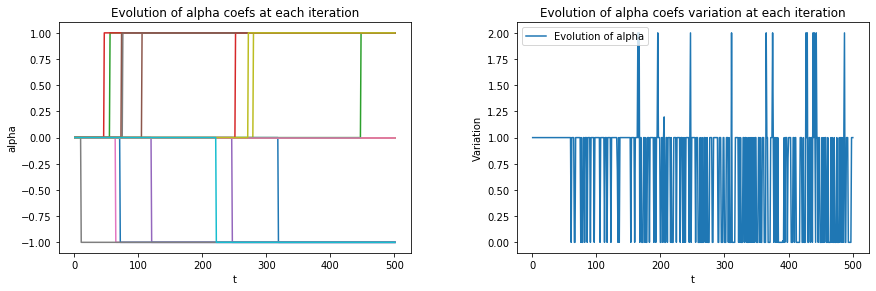

0.2191830244076662


In [15]:
alpha_hat, w_hat = SDCA(y_train, chosen_loss, X_train, T // 2, chosen_output, True)
alpha_hat, w_hat = alpha_hat[-1], w_hat[-1]
y_hat = predict_y(w_hat, X_train)
print(mse(y_hat, y_train))

y_train_predict = predict_y(w_hat, X_train)
y_test_predict = predict_y(w_hat, X_test)

###### Display results for gen_arti

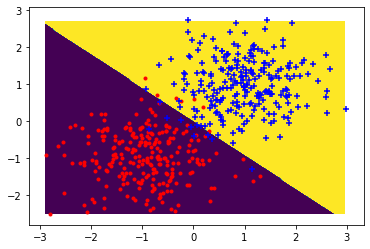

In [16]:
def predict(X):
    Y_pred = np.dot(X, w_hat)
    Y_pred[Y_pred > 0] = 1
    Y_pred[Y_pred <= 0] = -1
    return Y_pred


plot_frontiere(X_train, predict, step=200)
plot_data(X_train, y_train)
plt.show()

###### Plot train and test error

In [17]:
def plot_mse_data(y, loss, x, output_type, label, verbose=False):
    MSE = []
    for i in range(1, T // 5):
        MSEbis = []
        # Boucle permettant "d'annuler" l'effet de l'aléatoire
        for j in range(5):
            alpha_hat, w_hat = SDCA(y, loss, x, T // 2, output_type, verbose)
            w_hat = w_hat[5 * i]
            y_hat = predict_y(w_hat, x)
            MSEbis.append(mse(y_hat, y))
        MSE.append(np.mean(MSEbis))
    plt.plot([5 * i for i in range(1, T // 5)], MSE, label=label)
    # print(MSE)
    plt.xlabel("Nombre d'itérations")
    plt.ylabel("Erreur moyenne des moindres carrés")
    plt.legend()

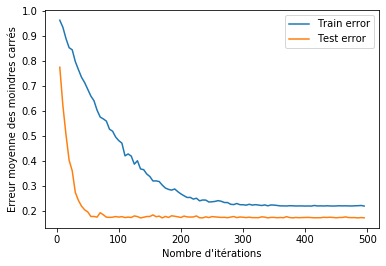

In [18]:
plot_mse_data(
    y_train, chosen_loss, X_train, chosen_output, label="Train error", verbose=False
)
plot_mse_data(
    y_test, chosen_loss, X_test, chosen_output, label="Test error", verbose=False
)
plt.show()

###### Display optimal primal and dual value and duality gap

In [19]:
print("Optimal primal value :", primal(y_train, X_train, w_hat, chosen_loss))
print("Optimal dual value :", dual(y_train, X_train, alpha_hat, chosen_loss))
print(
    "Duality gap for optimal values :",
    duality_gap(y_train, X_train, w_hat, alpha_hat, chosen_loss),
)
print("Minimum number of iterations :", nb_iter(1, 0.1))

Optimal primal value : [0.54386544]
Optimal dual value : [0.5185863]
Duality gap for optimal values : [0.02527914]
Minimum number of iterations : 3461.0
